![score2 table](https://www.louvainmedical.be/sites/default/files/content-site/Octobre2022/dmeuref-f1.jpg)

In [53]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/observations.db")

query = """
SELECT p.GENDER, t.smoker,cast(strftime('%Y.%m%d', date(l.date)) - strftime('%Y.%m%d', date(p.BIRTHDATE)) as INT) as age, l.ldl, s.sys
FROM patients p
JOIN (
    SELECT PATIENT, max(date(DATE)) as date, cast(VALUE as DECIMAL) / 18.018 as ldl
    FROM observations
    WHERE DESCRIPTION = 'Low Density Lipoprotein Cholesterol' AND UNITS = 'mg/dL'
    GROUP BY PATIENT
) l on p.Id = l.PATIENT
JOIN (
    SELECT PATIENT, max(date(DATE)) as date, cast(VALUE as INT) as sys
    FROM observations
    WHERE DESCRIPTION = 'Systolic Blood Pressure' AND UNITS = 'mm[Hg]'
    GROUP BY PATIENT
) s on p.Id = s.PATIENT
JOIN (
    SELECT PATIENT, max(date(DATE)) as date,
        CASE
            WHEN VALUE = 'Smokes tobacco daily (finding)' THEN 1
            WHEN VALUE = 'Ex-smoker (finding)' THEN 1
            WHEN VALUE = 'Never smoked tobacco (finding)' THEN 0
            ELSE 0
        END as smoker
    FROM observations
    WHERE DESCRIPTION = 'Tobacco smoking status'
    GROUP BY PATIENT
) t on p.Id = t.PATIENT;
"""

df = pd.read_sql(query, conn)

In [54]:
from lib.score2 import score2
score2('M', True, 49, 5.1, 159)

df2 = pd.DataFrame({
    'id': [],
    'gender': [],
    'smoker': [],
    'score2': []
})
id = 1
for index, row in df.iterrows():
    score = score2(row["GENDER"], row["smoker"], row["age"], row["ldl"], row["sys"])
    if score != -1:
        df2.loc[len(df2.index)] = [id, row["GENDER"], row["smoker"], score]
        id = id + 1

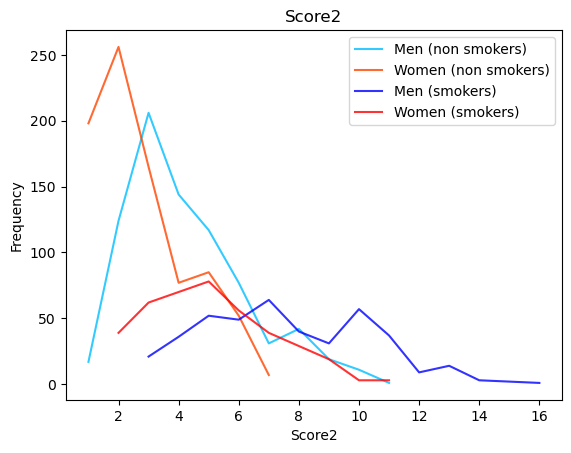

In [60]:
import matplotlib.pyplot as plt

wdf = df2.where(df2.gender == 'F').where(df2.smoker == 0).dropna().groupby(['gender', 'score2']).count().reset_index()
mdf = df2.where(df2.gender == 'M').where(df2.smoker == 0).dropna().groupby(['gender', 'score2']).count().reset_index()
wsdf = df2.where(df2.gender == 'F').where(df2.smoker == 1).dropna().groupby(['gender', 'score2']).count().reset_index()
msdf = df2.where(df2.gender == 'M').where(df2.smoker == 1).dropna().groupby(['gender', 'score2']).count().reset_index()

# plt.bar(mdf["score2"], mdf["id"], width=0.9, align='center', label='Men (non smokers)', alpha=0.5, color='deepskyblue')
# plt.bar(wdf["score2"], wdf["id"], width=0.9, align='center', label='Women (non smokers)', alpha=0.5, color='orangered')
# plt.bar(msdf["score2"], msdf["id"], width=0.9, align='center', label='Men (smokers)', alpha=0.5, color='b')
# plt.bar(wsdf["score2"], wsdf["id"], width=0.9, align='center', label='Women (smokers)', alpha=0.5, color='r')
plt.plot(mdf["score2"], mdf["id"], label='Men (non smokers)', alpha=0.8, color='deepskyblue')
plt.plot(wdf["score2"], wdf["id"], label='Women (non smokers)', alpha=0.8, color='orangered')
plt.plot(msdf["score2"], msdf["id"], label='Men (smokers)', alpha=0.8, color='b')
plt.plot(wsdf["score2"], wsdf["id"], label='Women (smokers)', alpha=0.8, color='r')
plt.xlabel('Score2')
plt.ylabel('Frequency')
plt.title('Score2')
plt.legend()
plt.show()